# TRABAJO FINAL DE LABORATORIO 
## TRABAJO A1 
### Arturo Sirvent Fresneda y Ángel Guevara Ros

## OBJETIVO 

El propósito del trabajo es crear una aplicación de clasificación de eventos sonoros  partiendo de un conjunto de muestras etiquetadas con sus clases correspondientes. 

Este tipo de problemas se caracteriza por la alta dimensionalidad y variabilidad presente en las clases, así como en la dificultad de disponer de muestras convenientemente etiquetadas.

Intentaremos abordar el problema tanto de forma supervisada como no supervisada, simulando que no se conocen algunas o todas las etiquetas del conjunto de datos.

## MÓDULOS

In [1]:
# módulos básicos
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

# módulos para manejar las muestras
import librosa, librosa.display
import IPython.display as ipd

import sklearn 

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# clasificación
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier ,plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC

from sklearn.neighbors import   NearestCentroid, \
                                KNeighborsClassifier, \
                                KernelDensity


# métricas
from sklearn.metrics import silhouette_samples, adjusted_rand_score, \
                            mutual_info_score, normalized_mutual_info_score, \
                            adjusted_mutual_info_score,  \
                            homogeneity_score, completeness_score, v_measure_score, \
                            fowlkes_mallows_score,silhouette_score, calinski_harabasz_score

#crossval y parameter estimation
from sklearn.model_selection import KFold,cross_validate, train_test_split, cross_val_score, \
                                    GridSearchCV

# importancia de características
from sklearn.inspection import permutation_importance




## FUNCIONES 

En este apartado, definiremos diferentes funciones que vamos a usar a lo largo del trabajo.

In [2]:
def transformacion_pca(data, srate, ncomp):
    Xf = librosa.feature.mfcc(y=data[0,:],
                        sr=srate,n_mfcc=20).flatten()    
    for s in range(1,n):
        Mfcc = librosa.feature.mfcc(y=data[s,:],
                        sr=srate,n_mfcc=20).flatten()    
        Xf = np.vstack([Xf,Mfcc])

    pca = sklearn.decomposition.PCA(n_components=ncomp)    
    pca.fit(Xf)
    X = pca.transform(Xf)
    return X,Xf


In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
def reduccion(X,n,c,nc):
    X_reduc=[]
    y_reduc=np.int16(np.kron(np.arange(c),np.ones(nc//2)))

    for i in range(0,n,nc):
        k_means=KMeans(n_clusters=nc//2, random_state=0)
        k_means.fit(X[i:(i+nc)])
        centros=k_means.cluster_centers_
        X_reduc.append(centros)
    X_reduc=np.array(X_reduc).reshape((360,464))
    return X_reduc, y_reduc

## PREPROCESADO DE DATOS

Aquí, importaremos y prepararemos los datos correspondientes a la tarea A1. Nuestros datos son señales de audio que contienen sonidos de animales. En particular, hay seis tipos de animales posibles y tendremos una cantidad balanceada de muestras de cada clase. 

A continuación, cargamos los datos y echamos un vistazo a las dimensiones de los mismos.

In [5]:
class_names = ['Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat']
srate = 22050        # frecuencia de muestreo
c = len(class_names) # número de clases

# cargamos los datos
data = np.load('./adata1.npy')

n,d = data.shape  # size and (raw) dimension
nc = n//c         # samples per class

print('%d samples from %d classes'%(n,c))
print('Raw dimension is %d corresponding to %.1f seconds of audio'%(d,d/srate))

# creamos las etiquetas
labs = np.int16(np.kron(np.arange(c),np.ones(nc)))


720 samples from 6 classes
Raw dimension is 66150 corresponding to 3.0 seconds of audio


Observamos que tenemos 720 muestras de cada una de las seis clases. Además cada muestra tienen un total de 66150 características que se obtienen de los tres segundos de duración de la señal de audio. 

Podemos escuchar una de las muestras para comprobar que existe cierto ruido en ellas que dificultará la clasificación. 

In [6]:
arow = np.random.randint(n)

sig = data[arow,:]

ipd.Audio(sig, rate=srate)

A la hora de trabajar con los datos, tenemos varias opciones: 

* Trabajar en el dominio temporal.

* Usar Espectrogramas de Mel.  

* Usar los Coeﬁcientes Cepstrales en las Frecuencias de Mel. 

Una vez elegido el espacio en el que queremos trabajar, es conveniente hacer una reducción de la dimensionalidad por PCA. 

En particular, nosotros hemos elegido trabajar con los Coeficientes Cepstrales en las Frecuencias de Mel. Una vez que hemos transformado nuestros datos a dicho espacio, llevamos a cabo una reducción de la dimensionalidad mediante PCA quedándonos con el 99% de las componentes. 

La elección de trabajar en este espacio se debe a que la reducción de características es notable y además no estamos perdiendo información importante. Este último aspecto se puede comprobar si tomamos por ejemplo un clasificador lineal y calculamos el acierto usando todas las características y luego usando las características reducidas. 


In [7]:
wc = LinearDiscriminantAnalysis()
y = labs

X, Xf = transformacion_pca(data,srate,ncomp=.99)   # Transformamos los datos al espacio nuevo y reducimos con PCA


print('Dimension: %d -> %d'%(Xf.shape[1],X.shape[1])) 
print('Resub. acc of a linear class.: %.2f -> %.2f'%(wc.fit(Xf,y).score(Xf,y),wc.fit(X,y).score(X,y)))

Dimension: 2600 -> 464
Resub. acc of a linear class.: 0.93 -> 0.94


Como se puede observar, hemos reducido el número de características hasta 464 e incluso hemos mejorado el acierto utilizando un clasificador lineal. Por tanto, de aquí en adelante, trabajaremos con los datos transformados a dicho espacio.

## CLUSTERING

En este apartado, nos planteamos un primer análisis de los datos. No usaremos las etiquetas y el objetivo será encontrar posibles patrones en nuestros datos y ver la compatibilidad con las etiquetas. 

Usaremos varios algoritmos de clustering para tener distintos puntos de vista. Para ver si los clusters son compatibles con las etiquetas reales del problema (que las conocemos), calcularemos algunas métricas como por ejemplo: 

* **Índice de Rand ajustado:** tiene en cuenta en lo que están de acuerdo y en lo que no están de acuerdo dos agrupamientos. Varía entre -1 y 1. Índices cercanos a cero quieren decir que son agrupamientos aleatorios.

* **Medida V:** compara la homogeneidad y la completitud entre dos agrupamientos. Varía entre 0 y 1, siendo 1 un parecido idéntico.

* **Índice de Silhouette:** nos da información sobre la dispersión de los clusters. Varía entre -1 y 1, y cuánto más grande sea, mejor será el agrupamiento hecho. Valores cercanos a cero indican solapamiento entre clusters.

### Clustering Jerárquico Aglomerativo

En este tipo de algoritmos, comenzamos con un cluster para cada muestra y vamos agrupando los dos clusters más parecidos en cada iteración hasta que llegamos a tener un único cluster para todo el conjunto de datos. Para caracterizar el parecido entre clusters, necesitamos la noción de distancia. 

El clustering aglomerativo es más popular que el divisivo debido a su eficiencia. Aún así, es un algoritmo costoso ya que en cada iteración tenemos que calcular la distancia con el nuevo cluster formado. 

La representación típica del clustering jerárquico es mediante dendrogramas, en los que en el eje X medimos la distancia entre clusters y en el eje Y la distancia entre puntos.

A continuación, aplicamos un algoritmo de clustering aglomerativo a nuestro conjunto de datos. No le fijaremos el número de clusters para que me haga el proceso hasta el final. 

Una vez hecho el clustering, dibujaremos su dendrograma y lo comentaremos.

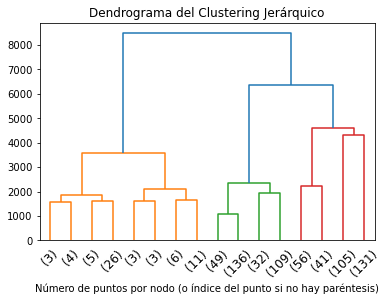

In [8]:
# Fijamos `distances_threshold=0` para que se calcule todo el árbol
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward' )   

# Lo entrenamos con nuestros datos
model = model.fit(X)

plt.title("Dendrograma del Clustering Jerárquico")
# fijando p=3 mostramos los tres primeros níveles del dendrograma.
plot_dendrogram(model, truncate_mode="level", p=3)  
plt.xlabel("Número de puntos por nodo (o índice del punto si no hay paréntesis)")
plt.xticks(rotation = 45)
plt.show()

Como hemos dicho antes, en el eje Y está representada la distancia entre puntos. A nosotros nos va a interesar que está distancia sea suficientemente grande ya que eso indicará que la partición hecha es estable. En cambio, cuando veamos un salto pequeño en el eje Y, eso indicará que la partición no es tan estable. 

Así, observando el dendrograma podríamos tomar varias decisiones: 

* Por un lado, cortar por la línea horizontal de 5000. Esto nos daría tres clusters, dos de ellos balanceados y uno con menor número de muestras. Estos clusters están lo suficientemente alejados para afirmar que no tienen patrones en común con el resto. 

* Por otro lado, podríamos decidir cortar por la línea horizontal de 4000. Esto supondría que ahora tendríamos cinco clusters con menos muestras cada uno.

* Por último, podríamos cortar por la línea horizontal de 3000, lo que nos daría una división en seis clusters.

Cualquiera de las tres decisiones puede ser buena, sin embargo hay factores que nos hace decidirnos por una. Si nos fijamos en el final del dendrograma, tenemos que la unión entre los grupos (105) y (131) se hace muy arriba. Esto quiere decir que la distancia entre ambos grupos es grande y, por tanto podría tener sentido que fueran lo suficientemente diferentes. Así, podríamos descartar el agrupamiento en tres clusters. 

Ya solo nos quedarían el agrupamiento en cinco y en seis clusters. El factor decisivo en este caso es el número de elementos en cada grupo. Si nos quedamos con el de seis clusters, entonces tendríamos dos clusters (los de la izquierda) con muy pocos elementos en comparación con el resto de grupos. 

Por tanto, viendo el dendrograma nosotros diríamos que a priori puede haber cinco grupos distintos en nuestros datos. 


Para comparar la información obtenida con las etiquetas reales del problema, lo que haremos será volver a hacer un clustering jerárquico pero ahora fijando el número de clusters a seis. Echaremos un vistazo a las etiquetas predichas y usaremos las métricas definidas para obtener algunos resultados cuantitativos. 

In [78]:
model = AgglomerativeClustering(n_clusters=6, linkage='ward' )   

model = model.fit(X)
y_Aggl = model.labels_

print('Indice de Rand Ajustado: %.2f '%adjusted_rand_score(y,y_Aggl))
print('Medida V: %.2f '% v_measure_score(y,y_Aggl))
print('Indice de Silhouette: %.2f '%silhouette_score(X, y_Aggl))

Indice de Rand Ajustado: 0.15 
Medida V: 0.26 
Indice de Silhouette: 0.13 


Observamos que los resultados obtenidos no son muy buenos. El índice de Rand ajustado junto con la medida V nos dicen que no hay mucho parecido entre las etiquetas predichas y las reales. 

El índice de Silhouette confirma lo mismo que las otras medidas y además como es un valor cercano a cero, nos indica que puede existir solapamiento entre los diferentes clusters. 

El solapamiento entre clusters hace más complicado este primer análisis sin las etiquetas.

### Clustering basado en densidad. MeanShift

En este tipo de métodos nos fijamos en la acumulación de puntos. Lo que buscamos son zonas densas dónde haya muchas muestras juntas y, dentro de las densas, nos interesarán las más densas posibles. 

Así, estos métodos consisten en elegir una región del espacio, calcular la media (o la moda) de los puntos que caigan dentro y moverme hacia ella. Con esto conseguimos movernos hacia una región más densa. Si repetimos esto de forma iterativa, acabaremos alcanzando la zona más densa de mi nube de puntos. 

Para seleccionar la región del espacio, se usan lo que se conoce como ventanas. Al mirar por la ventana lo que estamos haciendo es calcular la media ponderada de los puntos de esa región.

Precisamente en esto consiste el algoritmo **Meanshift**. Este método nos asegura la convergencia hacia un punto estacionario. Los puntos del espacio que converjan al mismo centro, pertenecerán al mismo cluster. 

Cabe destacar, que el algoritmo **Meanshift** supone que hay una gradación de la densidad de nuestros puntos. Si esto no ocurre, el algoritmo no funcionará correctamente. 

Uno de los hiperparámetros del algoritmo **Meanshift** es la anchura de la ventana. Si cogemos una ventana muy grande, puede que estemos teniendo en cuenta puntos muy alejados a la hora de calcular la media y entonces ésta nos salga desvíada hacia una región poco densa. Si cogemos una anchura de ventana muy pequeña, el tiempo de computación puede aumentar considerablemente. 

Existe una función que nos permite estimar este parámetro y será la que utilicemos. 

In [10]:
# Estimación de la anchura de ventana

bandwidth = estimate_bandwidth(X, quantile=0.3,random_state=0)

print("Estimated bandwidth=%.2f"%bandwidth)

Estimated bandwidth=687.78


Procedemos a utilizar el algoritmo **MeanShift**.

In [12]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, 
               cluster_all=True).fit(X)

y_ms = ms.labels_
cluster_centers = ms.cluster_centers_
y_ms_unique = np.unique(y_ms)
n_clusters_ = len(y_ms_unique ) - (1 if -1 in y_ms else 0)

print('Bandwidth: ' , bandwidth)
print("number of estimated clusters : %d" % n_clusters_)
print('Labels: ' , set(y_ms))

Bandwidth:  687.7779513888889
number of estimated clusters : 3
Labels:  {0, 1, 2}


Observamos que con la anchura de ventana estimada y nuestros datos, el resultado del MeanShift es que hay tres grupos solamente en nuestros datos. Sin embargo, nosotros sabemos que en realidad hay seis clusters correspondientes a cada una de las clases del problema, por lo que el resultado obtenido no es muy bueno. 

La respuesta que nos da el algoritmo MeanShift se puede deber a que existe solapamiento entre los clusters. Por tanto, no es capaz de distinguir seis regiones densas distintas, sino que esas zonas se entremezclan dando lugar a solo tres regiones. 

Para poder comparar de forma cuantitativa con las etiquetas reales del problema, vamos a jugar con el ancho de ventana para que el resultado del clustering sea de seis grupos. Por ejemplo, fijando `bandwidth=650` obtenemos dicho resultado.

In [13]:
bandwidth=650
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, 
               cluster_all=True).fit(X)

y_ms2 = ms.labels_
cluster_centers2 = ms.cluster_centers_
y_ms_unique2 = np.unique(y_ms2)
n_clusters_2 = len(y_ms_unique2 ) - (1 if -1 in y_ms2 else 0)

print('Bandwidth: ' , bandwidth)
print("number of estimated clusters : %d" % n_clusters_2)
print('Labels: ' , set(y_ms2))

Bandwidth:  650
number of estimated clusters : 6
Labels:  {0, 1, 2, 3, 4, 5}


Para comparar con las etiquetas reales, usamos las mismas métricas que hemos presentado al inicio del apartado. 

In [14]:
print('Indice de Rand Ajustado: %.2f '%adjusted_rand_score(y,y_ms2))
print('Medida V: %.2f '% v_measure_score(y,y_ms2))
print('Indice de Silhouette: %.2f '%silhouette_score(X, y_ms2))

Indice de Rand Ajustado: 0.01 
Medida V: 0.11 
Indice de Silhouette: 0.31 


El índice de Rand ajustado y la medida V nos indican que hay poca similitud en general y en cuanto a homogeneidad y completitud. 

El índice de Silhouette sin embargo, es algo mayor pero tampoco es muy bueno. Se aleja un poco del cero, lo que quiere decir que no existe tanto solapamiento entre los clusters calculados.  

Viendo las tres métricas calculadas, concluimos que tampoco es un clustering que sea compatible con las etiquetas reales.

### Conclusiones

Viendo los resultados de los dos algoritmos de clustering llevados a cabo, podemos concluir que éstos no son compatibles con las etiquetas reales en las que existen seis grupos de datos. Esto se puede deber a diversos factores: 

* Existencia de ruido en las muestras que dificulta la labor del agrupamiento. 

* Muestras que contengan atributos erróneos. 

* Solapamiento entre clusters. Probablemente producido por la cantidad de características de cada muestra que tenemos.

Este último punto lo abordaremos más adelante en el trabajo. Por eso, cuando hagamos una selección de las características más importantes, reduciendo así la dimensión, volveremos a probar los algoritmos de clustering para ver si mejoran los resultados. 

## ALGORITMOS SUPERVISADOS

## IMPORTANCIA DE CARACTERÍSTICAS

En este apartado, vamos a utilizar clasificadores del tipo árboles de decisión para intentar predecir las etiquetas de nuestro conjunto de datos. Usaremos este tipo de clasificadores porque entre sus atributos se encuentra la importancia de características. 

La importancia de las características es una información muy útil porque nos permite saber qué características no son relevantes para nuestro modelo. 

Entonces haremos lo siguiente: 

* Primero usaremos el árbol de decisión con los mejores parámetros calculados en el apartado anterior. 

* Depués veremos cuáles son las características más importantes con el atributo `feature_importances_`. 

* Finalmente, eliminaremos todas aquellas características que tengan una importancia de cero. Nos quedaremos con el resto y volveremos a entrenar el árbol de decisión para ver si mejoran (o no empeoran los resultados). 

Cabe destacar que, en el caso de los árboles de decisión, la importancia de una caracaterística se calcula como la reducción total (normalizada) del criterio de división (normalemente la impureza de Gini) al dividir por dicha característica

**Nota:** 

Si el clasificador que estamos usando no tiene directamente un atributo que nos de la importancia de las características, podemos usar la función `permutation_importance`. Esta implementación lo que hace es barajar una de las características y volver a entrenar el modelo con dicha característica permutada. Después comprueba si el rendimiento cambia mucho o no. Si cambia mucho, entonces diremos que esa variable es importante, y si cambia poco diremos que no lo es. Esto lo repite para cada una de las características y así nos ofrece un valor cuantitativo de la importancia de cada característica.

También lo probaremos en este apartado usando máquinas de vector soporte.

### Árboles de decisión

Así, vamos a calcular un "ranking" de características para nuestro árbol de decisión. 

Para ello, cogemos el árbol de decisión calculado en el apartado anterior y usamos el atributo de `feature_importances_` para ver la importancia de las características. Nos quedaremos con aquellas cuya importancia sea no nula.

In [26]:
X_reduc, y_reduc = reduccion(X,n,c,nc)   # Lo hacemos porque aún no está hecho en el apartado 2. Luego no hará falta. 

Xtr, Xts, ytr, yts = train_test_split(X_reduc, y_reduc, test_size=0.3, shuffle=True, random_state=0)

In [27]:
# El árbol que mejores resultados nos daba con nuestros datos.
clf_tree = DecisionTreeClassifier(ccp_alpha=0.023015873015873003, random_state=0)
clf_tree.fit(Xtr,ytr)

DecisionTreeClassifier(ccp_alpha=0.023015873015873003, random_state=0)

Calculamos una estimación del acierto en entrenamiento y en test mediante cross-validation. 

In [35]:
print('OA train %0.2f' % np.mean(cross_val_score(clf_tree, Xtr, ytr, scoring='accuracy', cv=3)))
print('OA test %0.2f' % np.mean(cross_val_score(clf_tree, Xts, yts, scoring='accuracy', cv=3)))

OA train 0.57
OA test 0.59


Cálculo de las importancias.

In [62]:
importancias=clf_tree.feature_importances_
# print(importancias)           descomentar para ver el resultado exacto de la importancia de cada característica.      

Selección de características.

In [52]:
indices=np.where(importancias!=0)
X_reduc2=X_reduc[:,indices]
print(X_reduc2.shape)
X_reduc2= X_reduc2.reshape((360,5))
print(X_reduc2.shape)

(360, 1, 5)
(360, 5)


In [53]:
indices   # Características seleccionadas

(array([ 0,  1,  3,  5, 11], dtype=int64),)

Tras calcular la importancia de las características, observamos que tan solo hay cinco cuya importancia sea no nula. Por tanto, nos quedamos solo con esas características y volvemos a evaluar el rendimiento del clasificador.

In [30]:
Xtr, Xts, ytr, yts = train_test_split(X_reduc2, y_reduc, test_size=0.3, shuffle=True, random_state=0)

# El árbol que mejores resultados nos daba con nuestros datos.
clf_tree = DecisionTreeClassifier(ccp_alpha=0.023015873015873003, random_state=0)
clf_tree.fit(Xtr,ytr)

DecisionTreeClassifier(ccp_alpha=0.023015873015873003, random_state=0)

In [34]:
print('OA train %0.2f' % np.mean(cross_val_score(clf_tree, Xtr, ytr, scoring='accuracy', cv=3)))
print('OA test %0.2f' % np.mean(cross_val_score(clf_tree, Xts, yts, scoring='accuracy', cv=3)))

OA train 0.57
OA test 0.59


Observamos que tras eliminar la gran mayoría de las características, los aciertos en test y en entrenamiento no han cambiado. Esto se debe a que tan solo había unas pocas características relevantes para nuestro árbol de clasificación que son las que estaban tomando realmente las decisiones. El resto de atributos no participaba.

### SVM

Vamos a hacer también una selección de características para el caso en el que estamos clasificando con una máquina de vector soporte. Lo separamos del caso anterior porque las características que son importantes para un método puede que no lo sean para otro. 

De hecho, el clasificador de las máquinas de vector soporte (SVC) no tiene un atributo como tal que nos dé la importancia de las características, sino que tenemos que usar una función auxiliar (Ver nota). 

Así, cogemos de nuevo el SVC con los parámetros óptimos calculado en el apartado anterior y trabajamos sobre él.

In [40]:
X_reduc, y_reduc = reduccion(X,n,c,nc)   # Lo hacemos porque aún no está hecho en el apartado 2. Luego no hará falta. 

Xtr, Xts, ytr, yts = train_test_split(X_reduc, y_reduc, test_size=0.3, shuffle=True, random_state=0)

clf_svc = SVC(C=100.0, gamma=5.994842503189409e-07)
clf_svc.fit(Xtr,ytr)


print('OA train %0.2f' % np.mean(cross_val_score(clf_svc, Xtr, ytr, scoring='accuracy', cv=5)))
print('OA test %0.2f' % np.mean(cross_val_score(clf_svc, Xts, yts, scoring='accuracy', cv=5)))

OA train 0.76
OA test 0.69


Los resultados no son malos. Calculamos la importancia de las características usando  `permutation_importance` y nos quedamos solo con las relevantes. Volvemos a evaluar el modelo para ver si mejora (o no empeora).

In [42]:
resultado = permutation_importance(clf_svc, X_reduc, y_reduc,scoring='accuracy', n_repeats=5, random_state=0)

In [64]:
importancias_svc = resultado.importances_mean
#importancias_svc  #descomentar para ver los valores exactos de importancia de cada característica.

Selección de características.

In [59]:
indices2=np.where(importancias_svc > abs(1e-2))
X_reduc3=X_reduc[:,indices2]
print(X_reduc3.shape)
X_reduc3= X_reduc3.reshape((360,7))
print(X_reduc3.shape)

(360, 1, 7)
(360, 7)


In [60]:
indices2  # Las mismas características seleccionadas que con el atributo de los árboles + dos adicionales (2 y 4).

(array([ 0,  1,  2,  3,  4,  5, 11], dtype=int64),)

Una vez hecha la selección de las características más importantes, volvemos a entrenar el modelo con dichas características. Una vez entrenado, calculamos la estimación de aciertos para ver si no empeora con respecto al modelo con todas las características.

In [58]:
Xtr, Xts, ytr, yts = train_test_split(X_reduc3, y_reduc, test_size=0.3, shuffle=True, random_state=0)

clf_svc = SVC(C=100.0, gamma=5.994842503189409e-07)
clf_svc.fit(Xtr,ytr)


print('OA train %0.2f' % np.mean(cross_val_score(clf_svc, Xtr, ytr, scoring='accuracy', cv=5)))
print('OA test %0.2f' % np.mean(cross_val_score(clf_svc, Xts, yts, scoring='accuracy', cv=5)))

OA train 0.73
OA test 0.71


Es sorprendente que al eliminar características, los resultados en test incluso mejoran. Es cierto que en entrenamiento baja un poco el acierto, pero no es preocupante. Además, a nosotros nos interesa que en test vaya bien para que el modelo sea capaz de generalizar. 

La mejora del acierto en test se puede deber a que los datos pueden contener atributos con valores erróneos, o que tengan poca relevancia en el resultado de la clasificación. Por tanto, al eliminarlos estamos quitando la posibilidad de entrenar con valores erróneos al modelo.

Cabe destacar también que los aciertos están bastante balanceados, por lo que no debemos preocuparnos por el sobre ajuste.

### Clustering

Como comentamos en el apartado de clustering, una vez hecha la reducción de características puede ser interesante volver a realizar algún algoritmo de clustering para ver si los resultados mejoran al haber menos dimensiones. 

Así, aquí simplemente repetimos lo hecho anteriormente pero sobre el conjunto que contiene solo las características importantes.

#### Clustering Jerárquico Aglomerativo

Volvemos a hacer clustering aglomerativo imponiendo que me calcule seis clusters. Además, calculamos los mismo índices que en el primer apartado para comparar con las etiquetas reales y ver si ha habido una mejora significativa.

In [73]:
model = AgglomerativeClustering(n_clusters=6, linkage='ward' )   

model = model.fit(X_reduc2)
y_Aggl2 = model.labels_

print('Indice de Rand Ajustado: %.2f '%adjusted_rand_score(y_reduc,y_Aggl2))
print('Medida V: %.2f '% v_measure_score(y_reduc,y_Aggl2))
print('Indice de Silhouette: %.2f '%silhouette_score(X_reduc2, y_Aggl2))

Indice de Rand Ajustado: 0.12 
Medida V: 0.28 
Indice de Silhouette: 0.26 


A la vista de los resultados, no parece que haya mejorado mucho el resultado del clustering. Por tanto, parece que la dimensionalidad en este caso no era tan importante. 

Que los resultados no hayan cambiado mucho puede deberse a que las características más importantes siguen estando solapadas entre sí, lo que dificulta mucho la labor de buscar patrones y establecer grupos.

#### MeanShift

Comprobamos si con el clustering basado en densidad conseguimos mejorar los resultados.

In [76]:
# Estimación de la anchura de ventana

bandwidth = estimate_bandwidth(X_reduc2, quantile=0.3,random_state=0)

print("Estimated bandwidth=%.2f"%bandwidth)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, 
               cluster_all=True).fit(X_reduc2)

y_ms = ms.labels_
cluster_centers = ms.cluster_centers_
y_ms_unique = np.unique(y_ms)
n_clusters_ = len(y_ms_unique ) - (1 if -1 in y_ms else 0)

print('Bandwidth: ' , bandwidth)
print("number of estimated clusters : %d" % n_clusters_)
print('Labels: ' , set(y_ms))

Estimated bandwidth=412.18
Bandwidth:  412.18088024408564
number of estimated clusters : 1
Labels:  {0}


Volvemos a ver que el resultado del clustering no mejora y, en este caso, empeora la predicción de grupos con los parámetros estimados. 

Justamente en los algoritmos de clustering basados en densidad, puede que eliminar características no sea la mejor idea porque estamos eliminando muestras de nuestra nube de puntos. Por tanto, estamos quitando densidad a las regiones. Esta puede ser la razón por la que tras eliminar las características poco relevantes, el resultado sea que solo hay un cluster.

Cabe destacar también que al tener menos datos habría que ajustar un poco los parámetros de la función que nos estima el ancho de banda. En particular, el argumento `quantile`habría que disminuirlo un poco. 

## ENSEMBLES